#Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import iqr

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima
from pmdarima.utils import tsdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00


#Dataset

In [ ]:
file1 = 'https://docs.google.com/spreadsheets/d/1hJ1Y33SdfsDT0F6Gju1DYO4vfPh9ROx0Lxe-r60mgUQ/edit#gid=2077295731'
file2 = 'https://docs.google.com/spreadsheets/d/19lBCG3W1AeYObLzzGUGbMkOBiWytHvN9BhUgvIjYmQw/edit#gid=823865895'
file3 = 'https://docs.google.com/spreadsheets/d/1MV5JbTgTy4qhkKQi7n3yV_Wcpf4HhKXSh5gCjHhpNps/edit#gid=544497479'
file4 = 'https://docs.google.com/spreadsheets/d/1xoB9FYmumtqJmGvajBSwbP60xyqjijGorUn4lm4qlRI/edit#gid=1079280484'

file1_trf = file1.replace('/edit#gid=', '/export?format=csv&gid=')
file2_trf = file2.replace('/edit#gid=', '/export?format=csv&gid=')
file3_trf = file3.replace('/edit#gid=', '/export?format=csv&gid=')
file4_trf = file4.replace('/edit#gid=', '/export?format=csv&gid=')

In [ ]:
transaction_df = pd.read_csv(file1_trf, parse_dates=['Date'], dayfirst=True)
transaction_df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


In [ ]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 313.9+ KB


In [ ]:
product_df = pd.read_csv(file2_trf)
product_df

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
5,P6,Cashew,18000
6,P7,Coffee Candy,9400
7,P8,Oat,16000
8,P9,Yoghurt,10000
9,P10,Cheese Stick,15000


In [ ]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [ ]:
customer_df = pd.read_csv(file3_trf)
customer_df

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"
...,...,...,...,...,...
442,443,33,1,NaN,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"


In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [ ]:
store_df = pd.read_csv(file4_trf)
store_df

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845
5,6,Lingga,Lingga,Modern Trade,-5.135399,119.423790
6,7,Buana Indah,Buana,General Trade,3.316694,114.590111
7,8,Sinar Harapan,Harapan Baru,General Trade,5.548290,95.323753
8,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643
9,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513


In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes


#Data Cleaning

##Handling null

In [ ]:
#transaction_df
transaction_df.isna().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [ ]:
# product_df
product_df.isna().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [ ]:
# customer_df - found null in marital
customer_df.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [ ]:
#I don't remove null values because: 1. ARIMA will not use marital status data, 2. Kmeans clustering also will not use marital status
customer_df[customer_df['Marital Status'].isna()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [ ]:
# store_df
store_df.isna().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

##Handling data type

In [ ]:
# transaction_df
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 313.9+ KB


In [ ]:
# transaction_df - change customerid, productid, storeid to string
type_col = ['CustomerID', 'ProductID', 'StoreID']
for i in type_col:
  transaction_df[i] = transaction_df[i].astype('str')

transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   object        
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 313.9+ KB


In [ ]:
# product_df
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [ ]:
# product_df - change productid to str
product_df['ProductID'] = product_df['ProductID'].astype('str')
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [ ]:
# customer_df
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [ ]:
# customer_df - change customerid to str
customer_df['CustomerID'] = customer_df['CustomerID'].astype('str')

# customer_df - assign gender 0 to Wanita, gender 1 to Pria
customer_df['Gender'] = np.where(customer_df['Gender']==0, 'Wanita',
                                 np.where(customer_df['Gender']==1, 'Pria', np.nan))
customer_df['Gender'].unique()

array(['Pria', 'Wanita'], dtype=object)

In [ ]:
customer_df['Income'].head()

0    5,12
1    6,23
2    9,17
3    4,87
4    3,57
Name: Income, dtype: object

In [ ]:
# customer_df - replace , to . in Income and change to float
customer_df['Income'] = customer_df['Income'].str.replace(',','.').astype('float')

In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    object 
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    object 
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.6+ KB


In [ ]:
# store_df
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes


In [ ]:
# store_df - change storeid to str
store_df['StoreID'] = store_df['StoreID'].astype('str')

In [ ]:
store_df[['Latitude', 'Longitude']]

,Latitude,Longitude
0,-6.200000,106.816666
1,-6.914864,107.608238
2,-7.797068,110.370529
3,-6.966667,110.416664
4,-7.250445,112.768845
5,-5.135399,119.423790
6,3.316694,114.590111
7,5.548290,95.323753
8,-3.654703,128.190643
9,3.597031,98.678513


In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     object 
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), object(4)
memory usage: 800.0+ bytes


##Handling duplicate

In [ ]:
# transaction_df
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   object        
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 313.9+ KB


In [ ]:
# transaction_df - allduplicate
transaction_df.duplicated().value_counts(dropna=False)

False    5020
dtype: int64

In [ ]:
# transaction_df - transactionid+productid duplicate - this should be asked to team that responsible in the
# data pipeline, from inputing to arrival at data mart/data warehouse
transaction_df.duplicated(subset=['TransactionID','ProductID']).value_counts()

False    5006
True       14
dtype: int64

In [ ]:
# product_df
product_df.duplicated().value_counts()

False    10
dtype: int64

In [ ]:
# customer_df
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    object 
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    object 
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.6+ KB


In [ ]:
# customer_df - allduplicate
customer_df.duplicated().value_counts()

False    447
dtype: int64

In [ ]:
# store_df
store_df.duplicated().value_counts()

False    14
dtype: int64

##Handling illogical data and outlier

In [ ]:
# transaction_df
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   object        
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 313.9+ KB


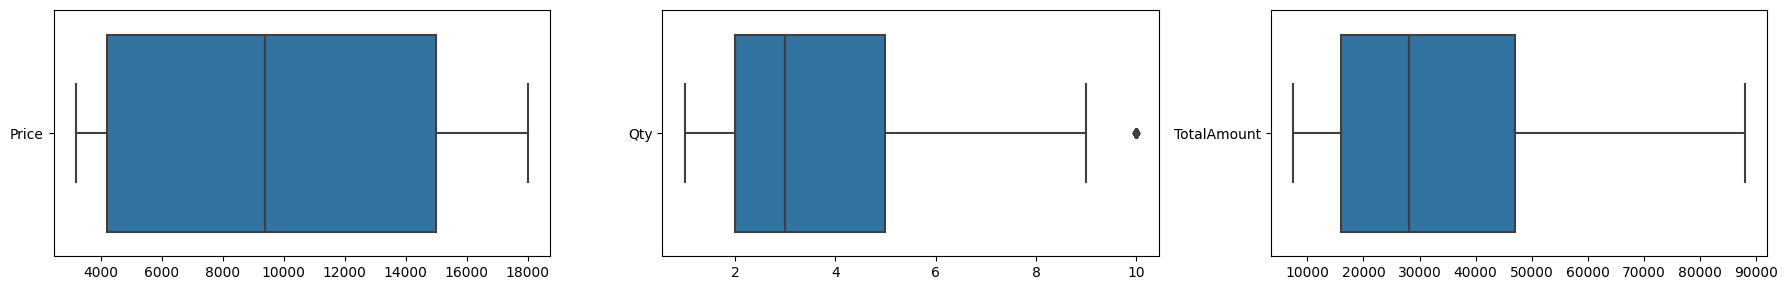

In [ ]:
# I don't remove outlier in this step, I'll remove when it's used in Kmeans clustering
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,3))

for i,v in enumerate(transaction_df.select_dtypes('int').columns):
  temp = transaction_df[[v]]
  sns.boxplot(data=temp, ax=ax[i], orient='h')

fig.tight_layout()
plt.show()

In [ ]:
# product_df
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


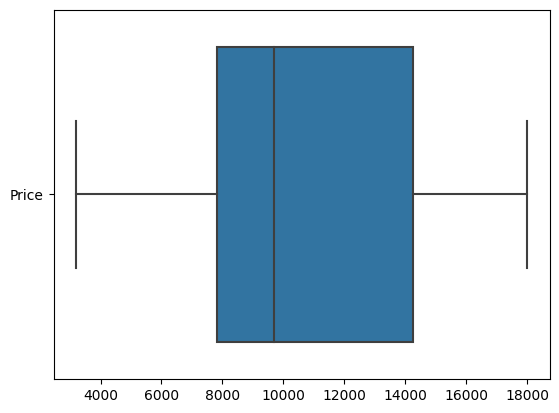

In [ ]:
sns.boxplot(data=product_df[['Price']], orient='h')
plt.show()

In [ ]:
# customer_df
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    object 
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    object 
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.6+ KB


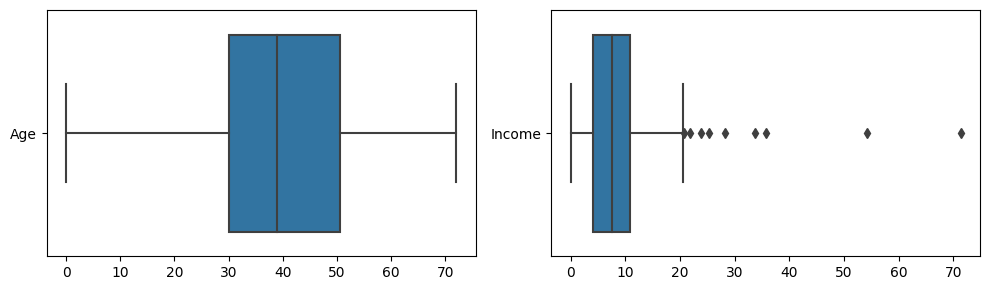

In [ ]:
# I don't remove outlier in this step, I'll remove when it's used in Kmeans clustering
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

for i,v in enumerate(customer_df.select_dtypes(np.number).columns):
  temp = customer_df[[v]]
  sns.boxplot(data=temp, ax=ax[i], orient='h')

fig.tight_layout()
plt.show()

In [ ]:
# store_df
store_df.info()
display(store_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     object 
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), object(4)
memory usage: 800.0+ bytes


,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845
5,6,Lingga,Lingga,Modern Trade,-5.135399,119.423790
6,7,Buana Indah,Buana,General Trade,3.316694,114.590111
7,8,Sinar Harapan,Harapan Baru,General Trade,5.548290,95.323753
8,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643
9,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513


#ARIMA

##Identify Seasonality

In [ ]:
# prepare the data
arima_df = transaction_df[['Date', 'Qty']].copy().sort_values(by='Date').groupby('Date')[['Qty']].sum()
arima_df.info()
display(arima_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Qty     365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30


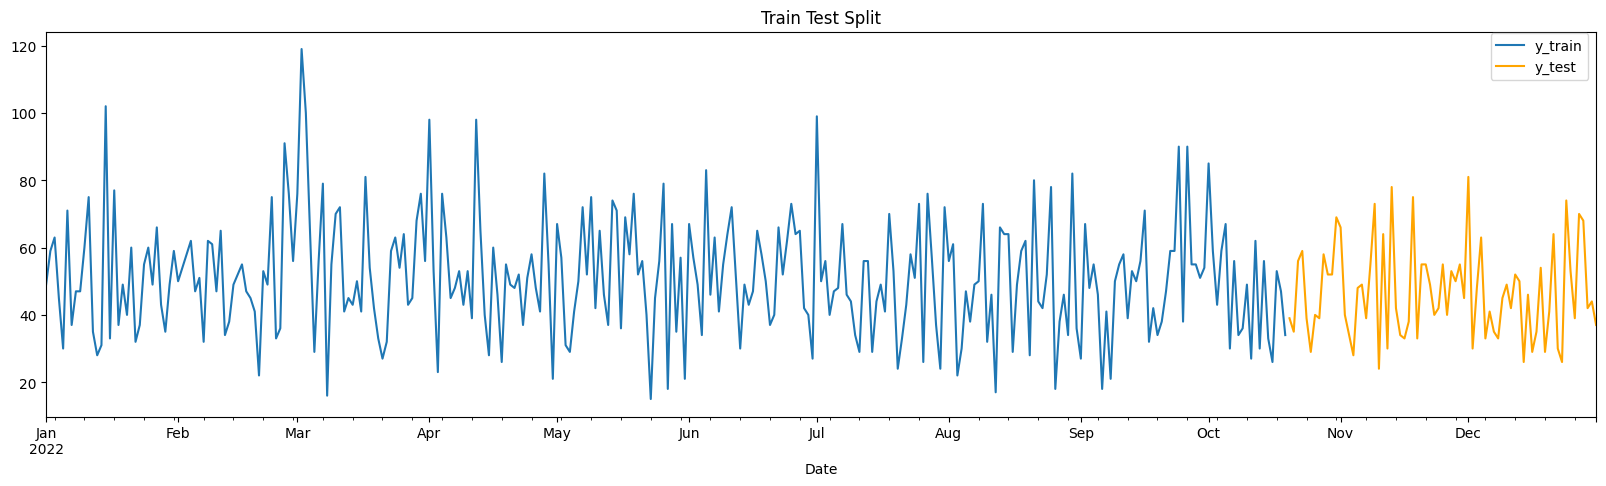

In [ ]:
# train_test_split
arima_df_len = round(len(arima_df)*0.8)
y_train, y_test = arima_df[['Qty']].iloc[:arima_df_len], arima_df[['Qty']].iloc[arima_df_len:]

fig, ax = plt.subplots(figsize=(20,5))
y_train.plot(ax=ax)
y_test.plot(ax=ax, c='orange')

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[1]],
          ['y_train', 'y_test'],
          loc='upper right', fontsize=10,
          title='', bbox_to_anchor=(0.995, 0.995), borderaxespad=0.0)
ax.set_title('Train Test Split')
plt.show()
fig.savefig('ttsplit.png', format='png', bbox_inches='tight', dpi=200)

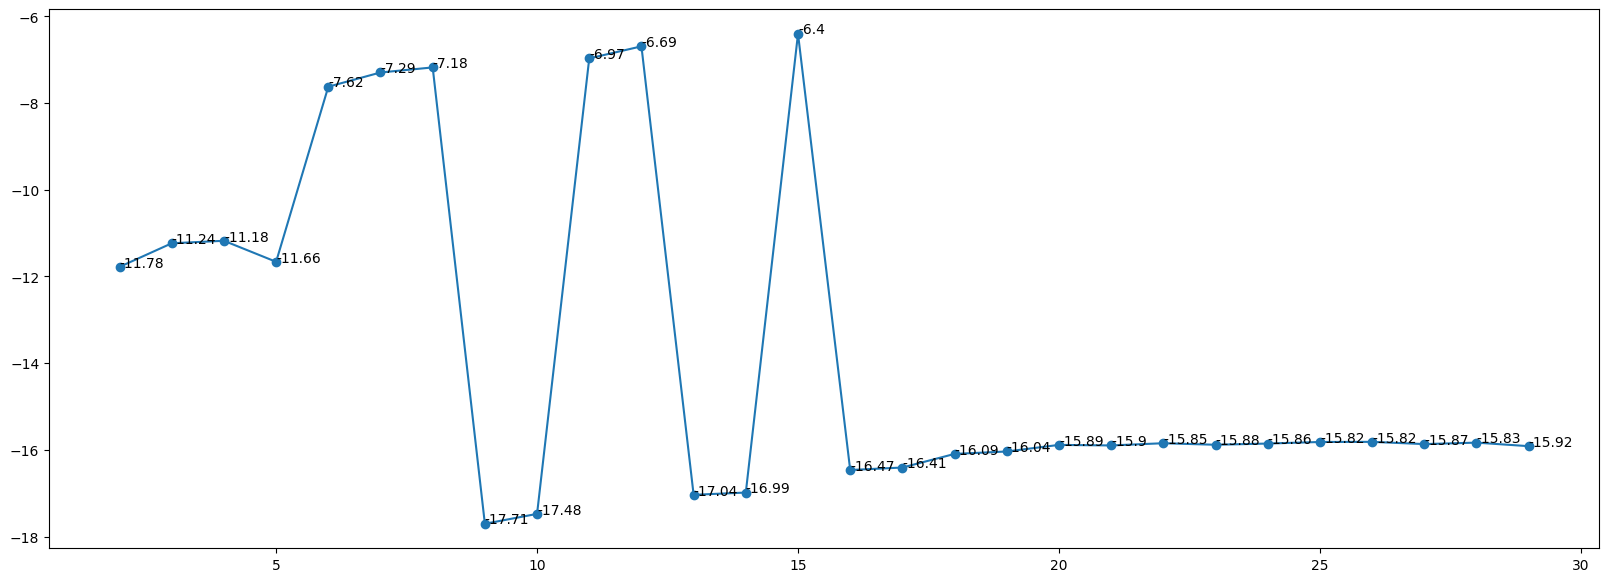

In [ ]:
#Determine seasonality
di = {}

for i in range(2, 30, 1):
  acf_data = y_train.copy()
  acf_data = acf_data - acf_data.rolling(i).mean()
  acf_data.dropna(inplace=True)

  try:
    result = adfuller(acf_data)
    di[i] = result[0].round(10)
  except:
    break

fig, ax = plt.subplots(figsize=(20,7))
plt.plot(di.keys(), di.values(), marker='o')
for i,v in di.items():
  plt.text(i, v, round(v,2))
plt.show()

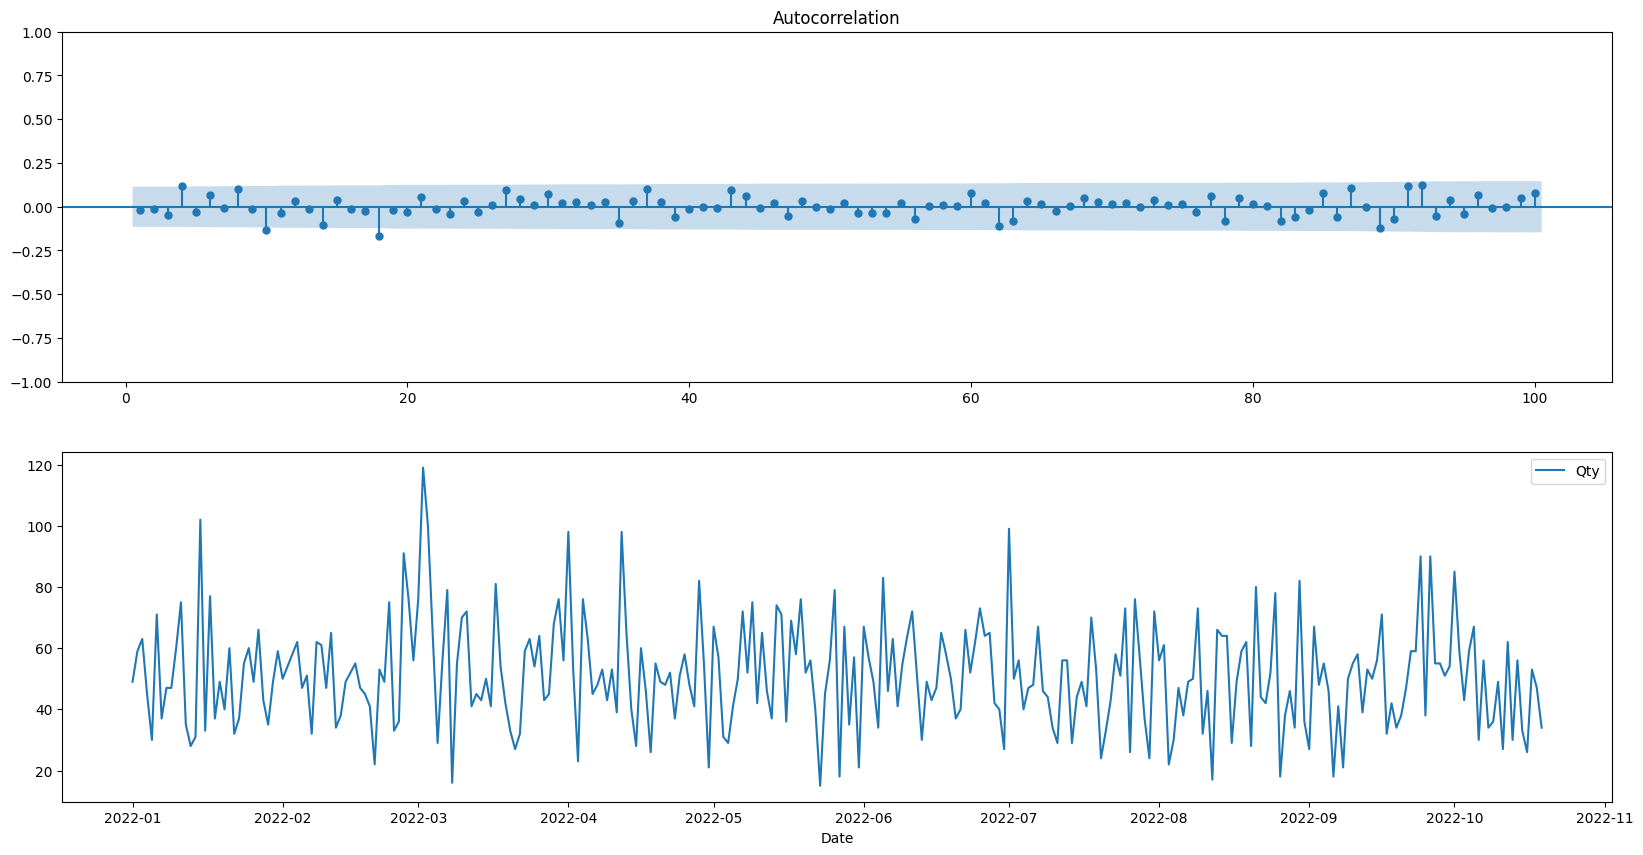

In [ ]:
# No seasonality
acf_data = y_train.copy()
acf_data = acf_data - acf_data.rolling(9).mean()
acf_data.dropna(inplace=True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plot_acf(acf_data, lags=100, zero=False, ax=ax[0])
sns.lineplot(acf_data, ax=ax[1])
plt.show()
fig.savefig('autocorrelation_daily.png', format='png', bbox_inches='tight', dpi=200)

No seasonality

##Decide the correct differencing and create the model

In [ ]:
# decide the correct differencing and create model
model = auto_arima(y_train, trace=True, suppress_warnings=True, max_p=20, max_d=20,
                   max_q=20)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2500.829, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2494.528, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2496.416, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2496.413, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2498.422, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.870 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:                        SARIMAX   Log Likelihood               -1245.264
Date:                Thu, 31 Aug 2023   AIC                           2494.528
Time:                        10:51:35   BIC                           2501.882
Sample:                    01-01-2022   HQIC                          2497.474
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.0205      1.069     47.722      0.000      48.925      53.116
sigma2       296.2872     22.615     13.102      0.000     251.963     340.611
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                19.60
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.55
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##Plot diagnostics

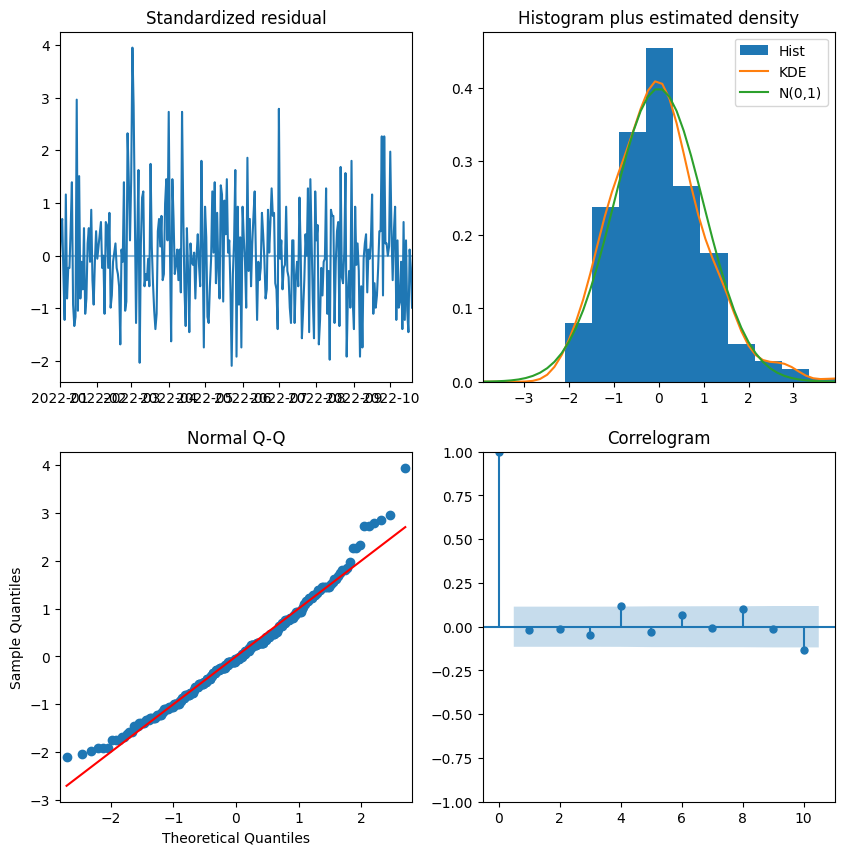

In [ ]:
# plot_diagnostics
fig = model.plot_diagnostics(figsize=(10,10))
plt.show()

fig.savefig('plot_diagnostics.png', format='png', bbox_inches='tight', dpi=200)

##Prediction

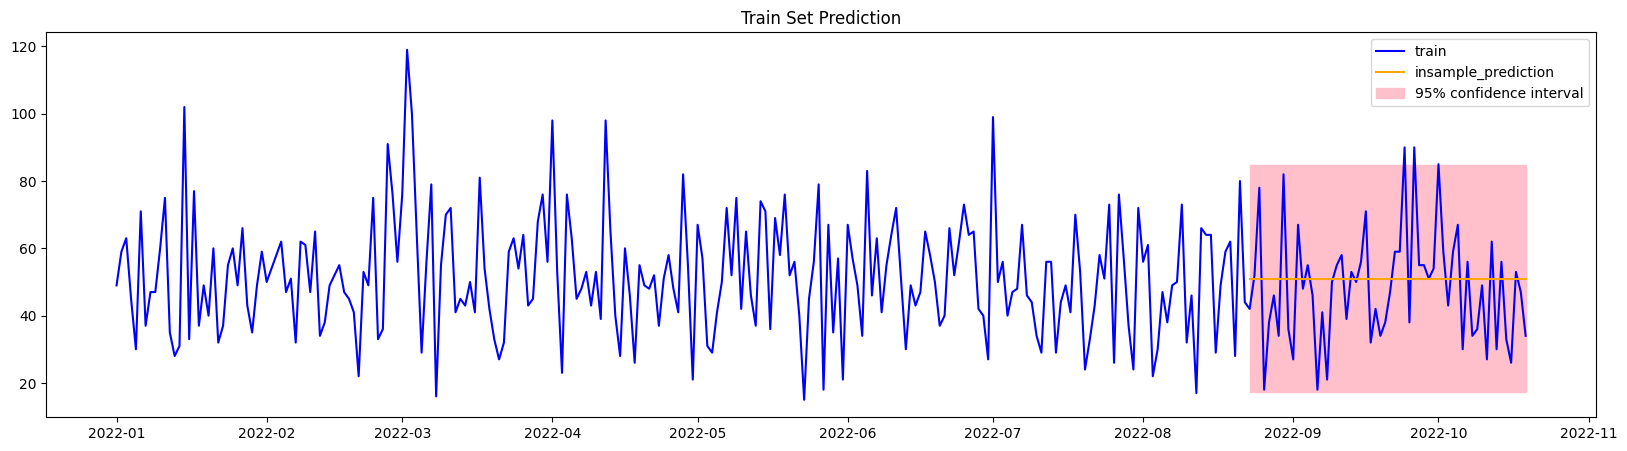

In [ ]:
# in-sample
in_sample_len = round(len(y_train)*0.8)
fig, ax = plt.subplots(figsize=(20,5))

insample, conf_int = model.predict_in_sample(start=in_sample_len, return_conf_int=True, alpha=0.05)
insample = insample.reset_index()
conf_int = pd.DataFrame(conf_int, columns=[1,2])
insample = pd.concat([insample, conf_int], axis=1).set_index('index')

ax.plot(y_train, c='blue', label='train')
ax.plot(insample[0], c='orange', label='insample_prediction')
ax.fill_between(insample.index, insample[1], insample[2], color='pink', label='95% confidence interval')
ax.set_title('Train Set Prediction')
ax.legend()
plt.show()
fig.savefig('insample_prediction.png', format='png', bbox_inches='tight', dpi=200)

In [ ]:
# Print the train set error:
print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_train[in_sample_len:], insample[0])))

RMSE: 16.862


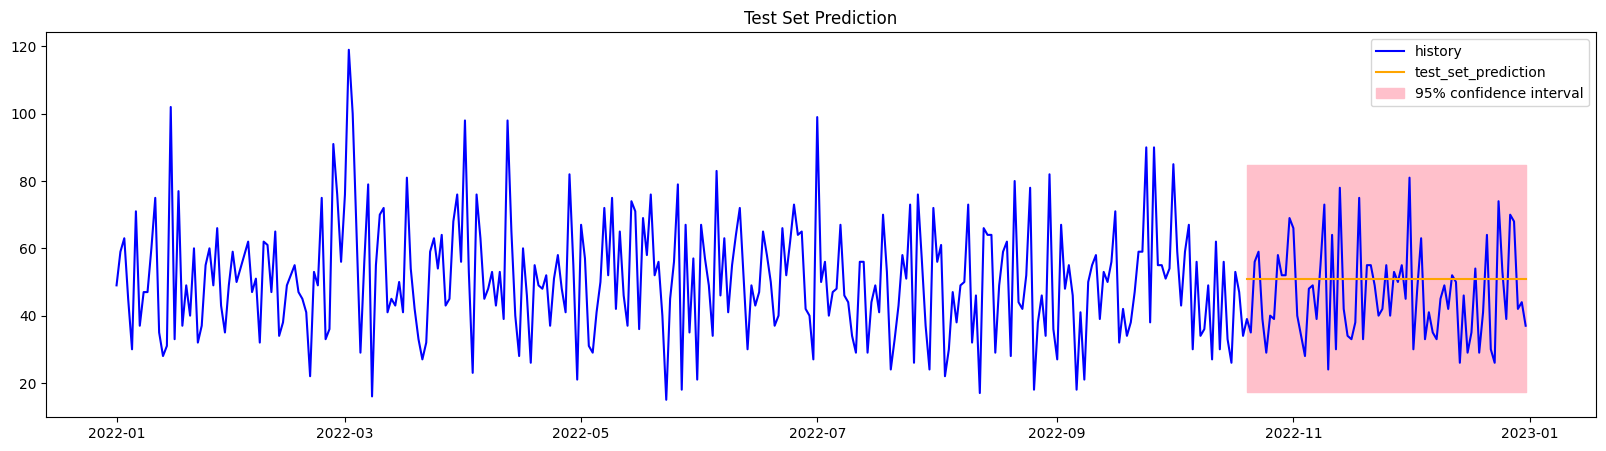

In [ ]:
# test_set_prediction
fig, ax = plt.subplots(figsize=(20,5))

y_pred, conf_int = model.predict(n_periods = len(y_test), return_conf_int=True, alpha=0.05)
forecast = y_pred.reset_index().rename(columns={'index':'month'})
conf_int = pd.DataFrame(conf_int, columns=[1,2])
forecast = pd.concat([forecast, conf_int], axis=1).set_index('month').rename(columns=dict(zip([0,1,2],['Qty','LowerBound','UpperBound'])))

ax.plot(arima_df['Qty'], c='blue', label='history')
ax.plot(forecast['Qty'], c='orange', label='test_set_prediction')
ax.fill_between(forecast.index, forecast['LowerBound'], forecast['UpperBound'], color='pink', label='95% confidence interval')
ax.set_title('Test Set Prediction')
ax.legend()
plt.show()
fig.savefig('test_set_prediction.png', format='png', bbox_inches='tight', dpi=200)

In [ ]:
# Print the test set error:
print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 14.499


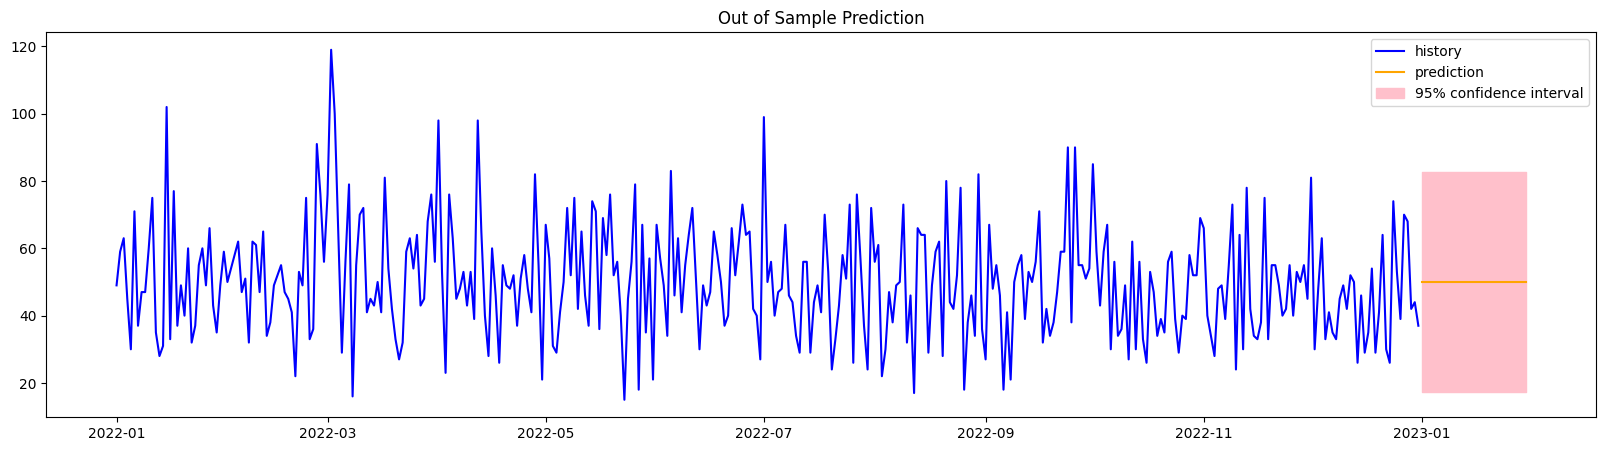

In [ ]:
# out_of_sample
history = arima_df.copy()
fig, ax = plt.subplots(figsize=(20,5))

model_fit = model.fit(history)
y_pred, conf_int = model_fit.predict(n_periods = 30, return_conf_int=True, alpha=0.05)
forecast = y_pred.reset_index().rename(columns={'index':'month'})
conf_int = pd.DataFrame(conf_int, columns=[1,2])
forecast = pd.concat([forecast, conf_int], axis=1).set_index('month').rename(columns=dict(zip([0,1,2],['Qty','LowerBound','UpperBound'])))
history = pd.concat([history, forecast], axis=0)

ax.plot(history['Qty'].loc[:'2022'], c='blue', label='history')
ax.plot(history['Qty'].loc['2023':], c='orange', label='prediction')
ax.fill_between(history.index, history['LowerBound'], history['UpperBound'], color='pink', label='95% confidence interval')
ax.set_title('Out of Sample Prediction')
ax.legend()
plt.show()
fig.savefig('out_of_sample.png', format='png', bbox_inches='tight', dpi=200)

In [ ]:
history.tail()

,Qty,LowerBound,UpperBound
2023-01-26,50.126027,17.430766,82.821289
2023-01-27,50.126027,17.430766,82.821289
2023-01-28,50.126027,17.430766,82.821289
2023-01-29,50.126027,17.430766,82.821289
2023-01-30,50.126027,17.430766,82.821289


#Kmeans Clustering

## Preparation and Removing Outlier

In [ ]:
# Merge All Data
master_df = transaction_df.merge(product_df, on='ProductID', how='left')\
                          .merge(customer_df, on='CustomerID', how='left')\
                          .merge(store_df, on='StoreID', how='left')
master_df.drop(columns='Price_y', inplace=True)
master_df.rename(columns={'Price_x':'Price'}, inplace=True)
master_df.info()
display(master_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   object        
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price           5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   object        
 8   Product Name    5020 non-null   object        
 9   Age             5020 non-null   int64         
 10  Gender          5020 non-null   object        
 11  Marital Status  4976 non-null   object        
 12  Income          5020 non-null   float64       
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,36,Wanita,Married,10.53,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,44,Pria,Married,14.58,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,27,Pria,Single,0.18,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,48,Pria,Married,12.57,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,33,Wanita,Married,6.95,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [ ]:
# Groupby: customerid, Aggregate: transaction_count, qty_sum, total_amount_sum
group_customer = master_df.groupby('CustomerID').agg({'TransactionID':'count','Qty':'sum','TotalAmount':'sum'})
group_customer.rename(columns=dict(zip(['TransactionID','Qty','TotalAmount'],
                                       ['transaction_count','qty_sum','total_amount_sum'])),
                      inplace=True)
group_customer.info()
display(group_customer.head())

<class 'pandas.core.frame.DataFrame'>
Index: 447 entries, 1 to 99
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   transaction_count  447 non-null    int64
 1   qty_sum            447 non-null    int64
 2   total_amount_sum   447 non-null    int64
dtypes: int64(3)
memory usage: 14.0+ KB


,transaction_count,qty_sum,total_amount_sum
CustomerID,,,
1,17,60,623300
10,14,50,478000
100,8,35,272400
101,14,44,439600
102,15,57,423300


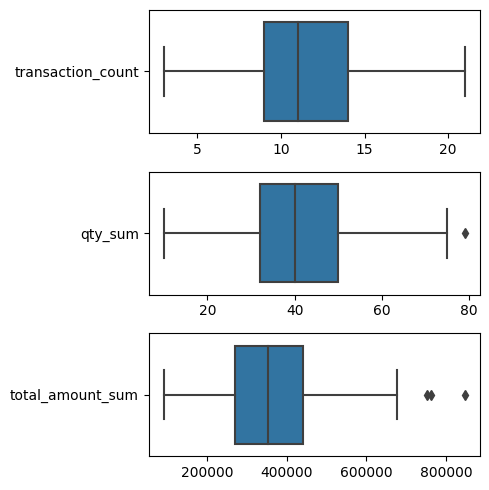

In [ ]:
# Visualize boxplot to see outlier
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,5))

for i,v in enumerate(group_customer.columns):
  temp = group_customer[[v]]
  sns.boxplot(data=temp, ax=ax[i], orient='h')

fig.tight_layout()
plt.show()

In [ ]:
# Remove outlier
group_customer_no_outlier = group_customer.copy()

# qty_sum
q1_qty_sum = np.quantile(group_customer_no_outlier['qty_sum'],0.25)
q3_qty_sum = np.quantile(group_customer_no_outlier['qty_sum'],0.75)
lb_qty_sum = q1_qty_sum - 1.5*(iqr(group_customer_no_outlier['qty_sum']))
ub_qty_sum = q3_qty_sum + 1.5*(iqr(group_customer_no_outlier['qty_sum']))
cond_qty_sum = (group_customer_no_outlier['qty_sum']>lb_qty_sum) & (group_customer_no_outlier['qty_sum']<ub_qty_sum)
group_customer_no_outlier = group_customer_no_outlier[cond_qty_sum]

# total_amount_sum
q1_amount_sum = np.quantile(group_customer_no_outlier['total_amount_sum'],0.25)
q3_amount_sum = np.quantile(group_customer_no_outlier['total_amount_sum'],0.75)
lb_amount_sum = q1_amount_sum - 1.5*(iqr(group_customer_no_outlier['total_amount_sum']))
ub_amount_sum = q3_amount_sum + 1.5*(iqr(group_customer_no_outlier['total_amount_sum']))
cond_amount_sum = (group_customer_no_outlier['total_amount_sum']>lb_amount_sum) & (group_customer_no_outlier['total_amount_sum']<ub_amount_sum)
group_customer_no_outlier = group_customer_no_outlier[cond_amount_sum]

# transaction_count
q1_transaction_count = np.quantile(group_customer_no_outlier['transaction_count'],0.25)
q3_transaction_count = np.quantile(group_customer_no_outlier['transaction_count'],0.75)
lb_transaction_count = q1_transaction_count - 1.5*(iqr(group_customer_no_outlier['transaction_count']))
ub_transaction_count = q3_transaction_count + 1.5*(iqr(group_customer_no_outlier['transaction_count']))
cond_transaction_count = (group_customer_no_outlier['transaction_count']>lb_transaction_count) & (group_customer_no_outlier['transaction_count']<ub_transaction_count)
group_customer_no_outlier = group_customer_no_outlier[cond_transaction_count]

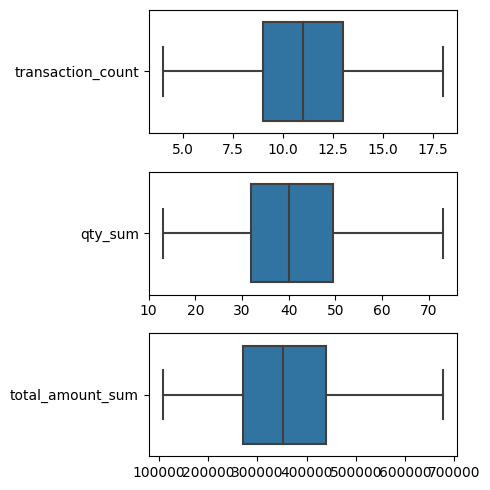

In [ ]:
# Boxplot after removing outlier
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,5))

for i,v in enumerate(group_customer_no_outlier.columns):
  temp = group_customer_no_outlier[[v]]
  sns.boxplot(data=temp, ax=ax[i], orient='h')

fig.tight_layout()
plt.show()

In [ ]:
group_customer_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 1 to 99
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   transaction_count  439 non-null    int64
 1   qty_sum            439 non-null    int64
 2   total_amount_sum   439 non-null    int64
dtypes: int64(3)
memory usage: 13.7+ KB


## Preprocessing

In [ ]:
preprocessing = group_customer_no_outlier.copy()

In [ ]:
# MinMaxScaler
mm = MinMaxScaler()
mm_preprocessing = mm.fit_transform(preprocessing[preprocessing.columns])

In [ ]:
# StandardScaler
ss = StandardScaler()
ss_preprocessing = ss.fit_transform(preprocessing[preprocessing.columns])

##Deciding N. Cluster

In [ ]:
kmeans_data = ss_preprocessing.copy()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

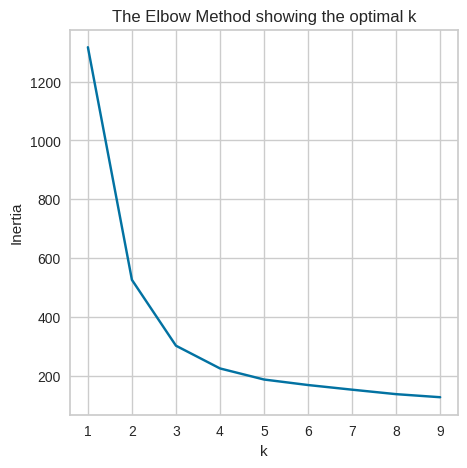

[1317.0000000000005, 525.62607042428, 301.6775074321927, 224.3327684346385, 186.64188590074656, 167.8992474433156, 152.06650877787246, 136.85996827234192, 126.42815728342104]


In [ ]:
# Elbow method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init='k-means++',random_state=10)
    kmeanModel.fit(kmeans_data)  #---------------------Ini yang diganti
    distortions.append(kmeanModel.inertia_)

fig = plt.figure(figsize=(5,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()
print(distortions)
fig.savefig('elbow.png', format='png', bbox_inches='tight', dpi=200)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=2, the average silhouette score is 0.478037573577512


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=3, the average silhouette score is 0.43355634271123344


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=4, the average silhouette score is 0.37468569459442336


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=5, the average silhouette score is 0.33528074665703417


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=6, the average silhouette score is 0.28606091683737345


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=7, the average silhouette score is 0.2861934780460523


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=8, the average silhouette score is 0.285157114634312


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=9, the average silhouette score is 0.2681348054679699


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=10, the average silhouette score is 0.27137488695596923


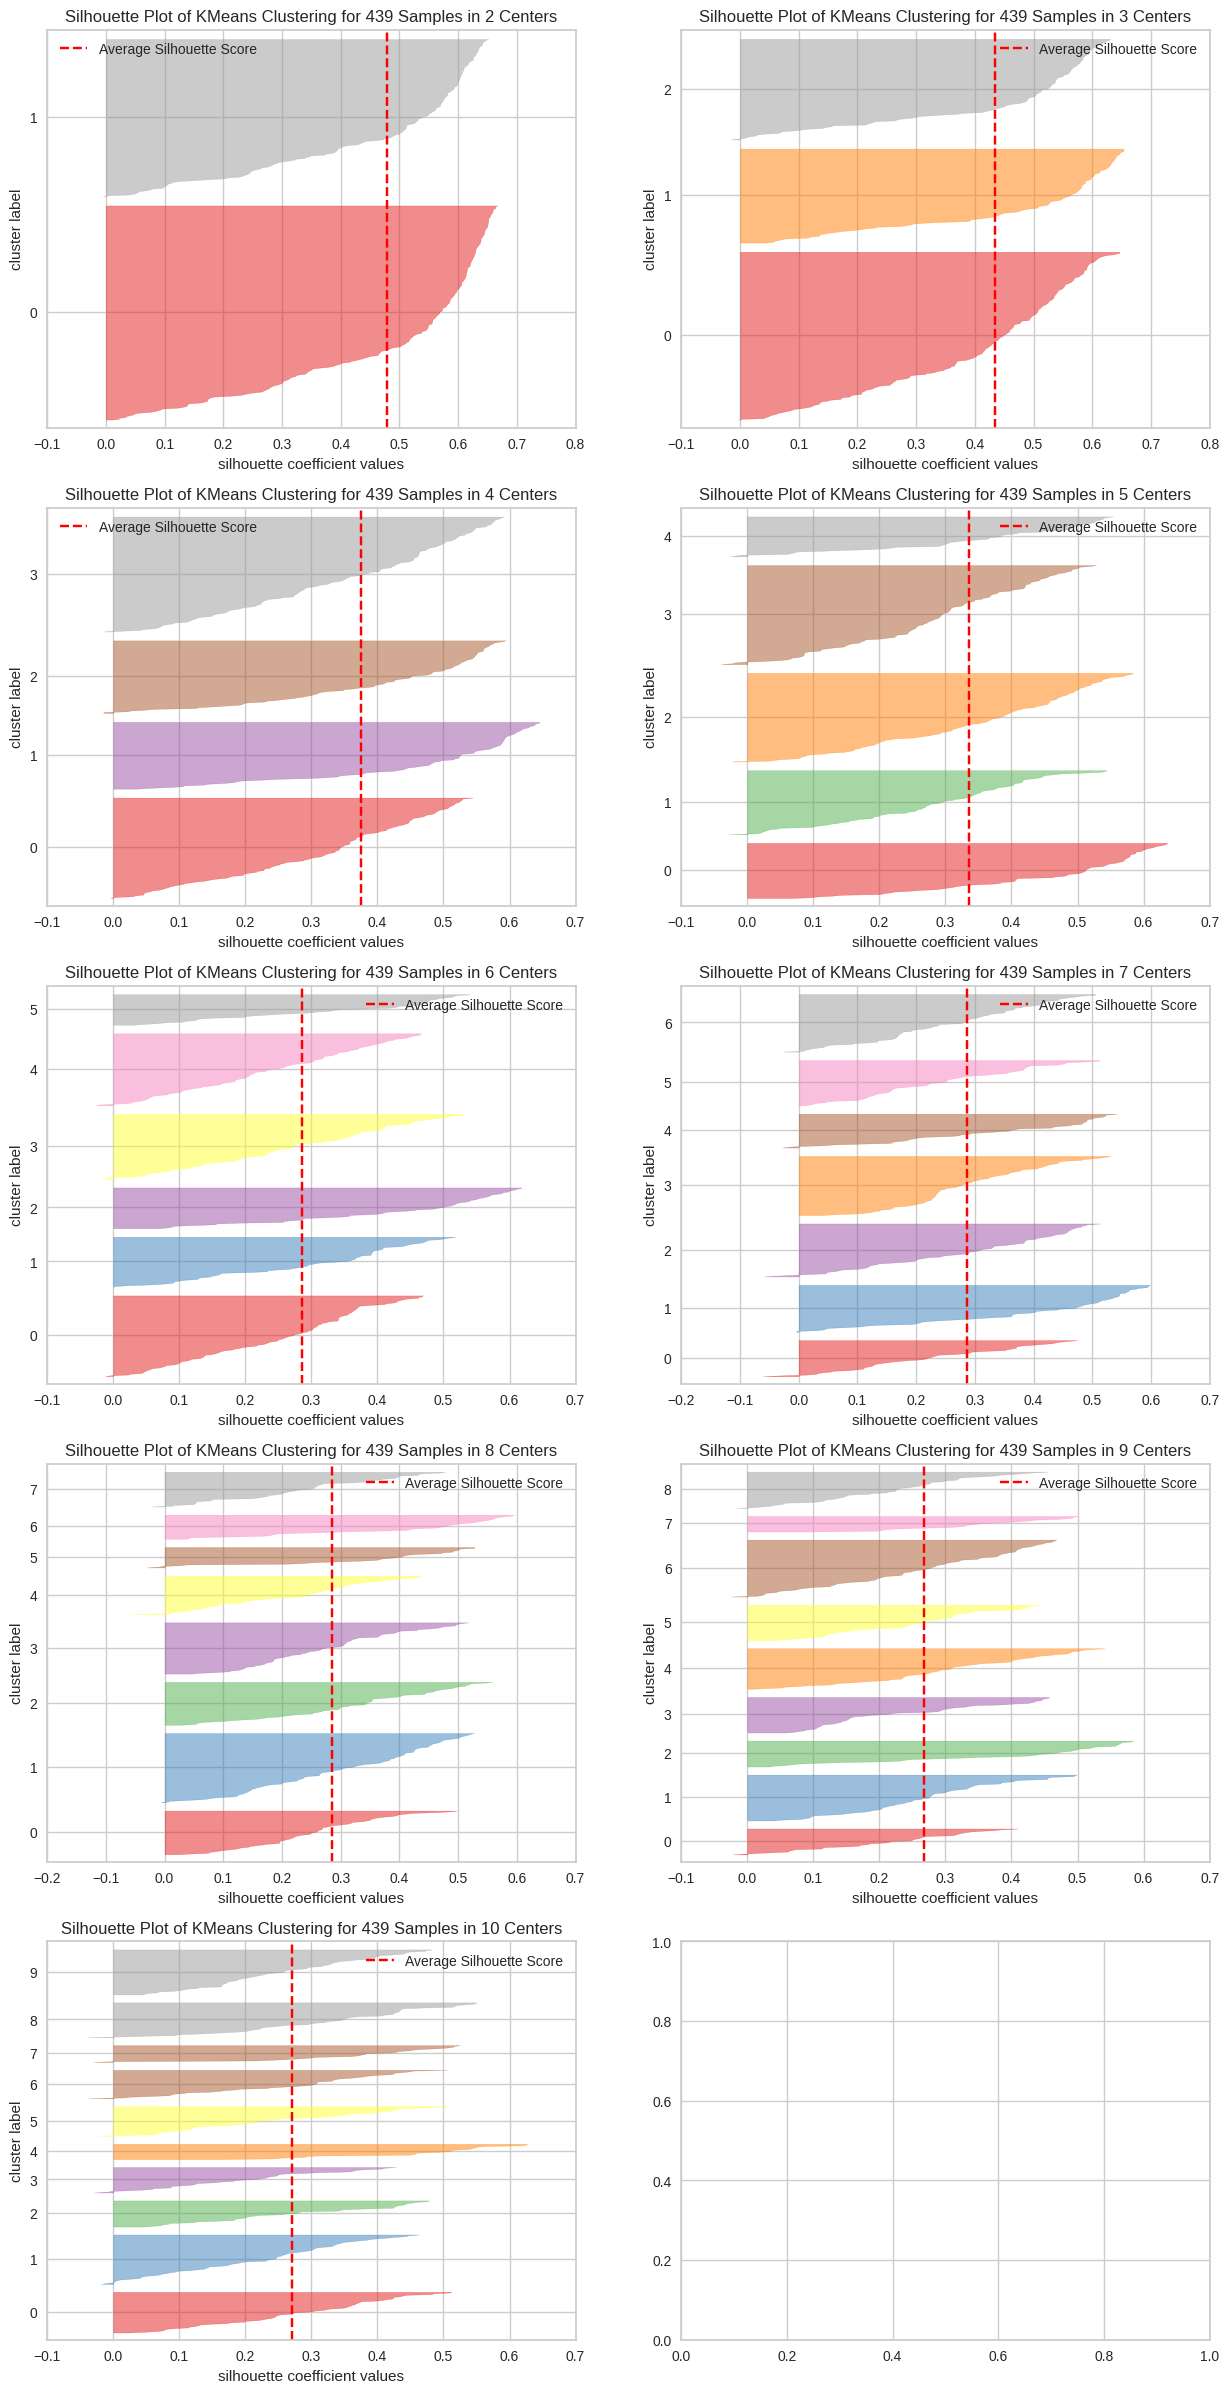

In [ ]:
# Silhouette score plot
K = range(2,11)
max_K = max(K)
fig, ax = plt.subplots(int(np.ceil(max_K/2)), 2, figsize = (15,30))

for n_clusters in K:
  kmeansModel = KMeans(n_clusters=n_clusters, init='k-means++', random_state=10)

  q, mod = divmod(n_clusters,2)
  sil = SilhouetteVisualizer(kmeansModel, is_fitted = False, ax = ax[q-1][mod])
  sil.fit(kmeans_data)
  sil.finalize()
  print(f"For k={n_clusters}, the average silhouette score is {sil.silhouette_score_}")

Based on Elbow Method and Silhouette Score, I choose 3 cluster

## Interpretation

In [ ]:
clustering_df = kmeans_data.copy()
predict_df = group_customer.copy()
interpretation_df = customer_df.set_index('CustomerID')\
                    .merge(group_customer, left_index=True, right_index=True,
                           how='inner')

# standardized predict_df
predict_df[predict_df.columns] = ss.transform(predict_df[predict_df.columns])

# fit on clustering_df, predict and get label from predict_df
cluster_model = KMeans(n_clusters=3, random_state=10, init='k-means++')
cluster_model.fit(clustering_df)
cluster_label = cluster_model.predict(predict_df)

# input the label into interpretation_df
predict_df['cluster'] = cluster_label
interpretation_df = interpretation_df.merge(predict_df['cluster'], left_index=True,
                                            right_index=True, how='inner')\
                                     .reset_index()
interpretation_df.info()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         447 non-null    object 
 1   Age                447 non-null    int64  
 2   Gender             447 non-null    object 
 3   Marital Status     444 non-null    object 
 4   Income             447 non-null    float64
 5   transaction_count  447 non-null    int64  
 6   qty_sum            447 non-null    int64  
 7   total_amount_sum   447 non-null    int64  
 8   cluster            447 non-null    int32  
dtypes: float64(1), int32(1), int64(4), object(3)
memory usage: 29.8+ KB


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [ ]:
# descriptive stats
interpretation_df.describe()

,Age,Income,transaction_count,qty_sum,total_amount_sum,cluster
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,39.782998,8.592103,11.230425,40.930649,362512.304251,0.834452
std,12.848719,6.607065,3.245302,12.756679,124634.279184,0.846715
min,0.000000,0.000000,3.000000,10.000000,92100.000000,0.000000
25%,30.000000,4.175000,9.000000,32.000000,271750.000000,0.000000
50%,39.000000,7.520000,11.000000,40.000000,354200.000000,1.000000
75%,50.500000,10.810000,14.000000,50.000000,441200.000000,2.000000
max,72.000000,71.300000,21.000000,79.000000,846700.000000,2.000000


In [ ]:
# descriptive stats for each cluster
cluster_group = interpretation_df.groupby('cluster')[interpretation_df.columns[:-1]].describe().T
cluster_group

cluster                              0              1              2
Age               count     203.000000     115.000000     129.000000
                  mean       40.443350      38.686957      39.720930
                  std        12.431615      13.255496      13.155902
                  min        18.000000       0.000000       2.000000
                  25%        31.000000      30.000000      29.000000
                  50%        40.000000      38.000000      39.000000
                  75%        51.000000      47.000000      51.000000
                  max        72.000000      70.000000      66.000000
Income            count     203.000000     115.000000     129.000000
                  mean        8.489754       8.929304       8.452558
                  std         5.904072       7.976940       6.346955
                  min         0.000000       0.000000       0.000000
                  25%         4.390000       3.845000       4.140000
                  50%         7.810000       6.980000       7.880000
                  75%        10.780000      12.380000      10.650000
                  max        35.780000      71.300000      54.200000
transaction_count count     203.000000     115.000000     129.000000
                  mean       11.004926       7.408696      14.992248
                  std         1.450495       1.555385       1.938492
                  min         7.000000       3.000000      11.000000
                  25%        10.000000       6.000000      14.000000
                  50%        11.000000       7.000000      15.000000
                  75%        12.000000       8.500000      16.000000
                  max        15.000000      11.000000      21.000000
qty_sum           count     203.000000     115.000000     129.000000
                  mean       39.581281      26.034783      56.333333
                  std         5.144164       5.793115       7.350949
                  min        26.000000      10.000000      44.000000
                  25%        36.000000      22.000000      51.000000
                  50%        40.000000      26.000000      55.000000
                  75%        43.000000      30.000000      61.000000
                  max        54.000000      39.000000      79.000000
total_amount_sum  count     203.000000     115.000000     129.000000
                  mean   348426.600985  220050.434783  511679.069767
                  std     51672.040640   49783.262483   82042.675323
                  min    215100.000000   92100.000000  365000.000000
                  25%    307600.000000  183300.000000  453500.000000
                  50%    349600.000000  228900.000000  498800.000000
                  75%    385750.000000  255100.000000  563300.000000
                  max    476200.000000  329300.000000  846700.000000

In [ ]:
# Age in each cluster
age_cluster = interpretation_df.groupby('cluster')['Age'].mean().to_frame()
age_cluster

,Age
cluster,
0,40.443350
1,38.686957
2,39.720930


In [ ]:
# gender ratio in each cluster
gender_cluster = interpretation_df.groupby('cluster')['Gender'].value_counts().to_frame()
gender_cluster

Gender
cluster Gender        
0       Wanita     112
        Pria        91
1       Wanita      63
        Pria        52
2       Wanita      67
        Pria        62

In [ ]:
# marital status in each cluster
marital_cluster = interpretation_df.groupby('cluster')['Marital Status'].value_counts(dropna=True).to_frame()
marital_cluster

Marital Status
cluster Marital Status                
0       Married                    157
        Single                      46
1       Married                     90
        Single                      25
2       Married                     93
        Single                      33

In [ ]:
# Income in each cluster
income_cluster = interpretation_df.groupby('cluster')['Income'].mean().to_frame()
income_cluster

,Income
cluster,
0,8.489754
1,8.929304
2,8.452558


In [ ]:
# transaction_count in each cluster
transaction_count_cluster = interpretation_df.groupby('cluster')['transaction_count'].mean().to_frame()
transaction_count_cluster

,transaction_count
cluster,
0,11.004926
1,7.408696
2,14.992248


In [ ]:
# qty_sum in each cluster
qty_sum_cluster = interpretation_df.groupby('cluster')['qty_sum'].mean().to_frame()
qty_sum_cluster

,qty_sum
cluster,
0,39.581281
1,26.034783
2,56.333333


In [ ]:
# total_amount_sum in each cluster
total_amount_sum_cluster = interpretation_df.groupby('cluster')['total_amount_sum'].mean().to_frame()
total_amount_sum_cluster

,total_amount_sum
cluster,
0,348426.600985
1,220050.434783
2,511679.069767


#Thank you!